Loaded 3 scenes


Rendering:   0%|          | 0/3 [00:00<?, ?it/s]

Saved to nuplan_results/roads_cars


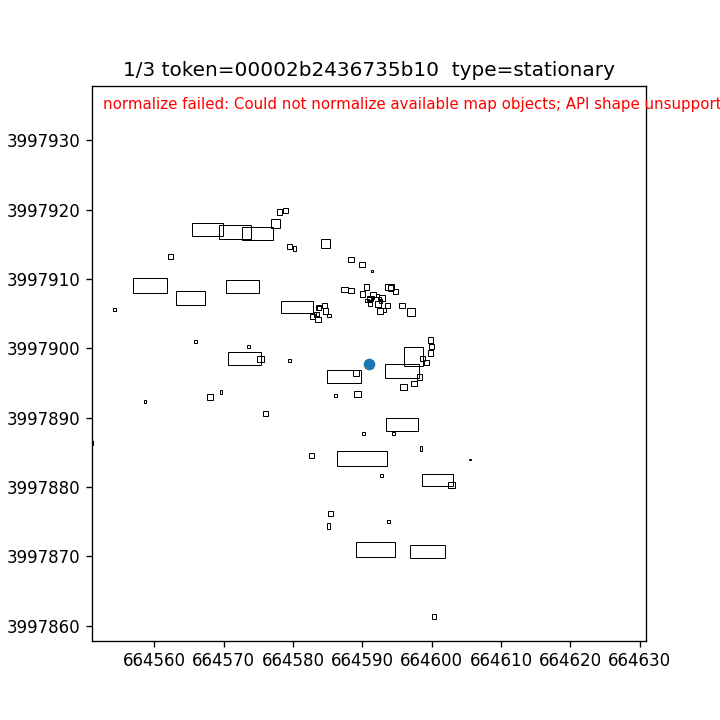

In [17]:
# ===== nuPlan mini → roads + cars (robust adapter) =====
import os, math, inspect
from pathlib import Path
from typing import Any, Dict, List, Tuple, Union
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
from IPython.display import Image, display
from tqdm.auto import tqdm
import imageio

from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter

# Enum import that works across nuPlan versions
try:
    from nuplan.common.maps.maps_datatypes import SemanticMapLayer
except Exception:
    from nuplan.common.maps.map_api import SemanticMapLayer  # type: ignore

# --- worker & filter (positional, tolerant to signature drift)
class _Worker:
    number_of_threads = 0
    def map(self, fn, iterable, chunksize: int = 1): return [fn(x) for x in iterable]

def _build_filter_positional(limit: int) -> ScenarioFilter:
    sig = inspect.signature(ScenarioFilter.__init__)
    params = [p for _, p in list(sig.parameters.items())[1:]]
    defaults = {
        "scenario_types": None, "scenario_tokens": None, "log_names": None, "map_names": None,
        "num_scenarios_per_type": None, "timestamp_threshold_s": 0.0, "ego_displacement_minimum_m": 0.0,
        "expand_scenarios": False, "shuffle": False, "limit_total_scenarios": limit,
        "remove_invalid_goals": False, "num_scenarios_per_log": None, "subsample_ratio": None,
    }
    return ScenarioFilter(*[defaults.get(p.name, None) for p in params])

# ---------- MAP HELPERS ----------
def _enumify(k):
    if isinstance(k, SemanticMapLayer): return k
    if isinstance(k, str):
        try: return SemanticMapLayer[k]
        except Exception: pass
    try: return SemanticMapLayer(int(k))
    except Exception: return None

def _fetch_map_object(mp, layer, oid):
    """Try several signatures for get_map_object / get_one_map_object."""
    if hasattr(mp, "get_map_object"):
        fn = mp.get_map_object
        for args, kwargs in [
            ((layer, oid), {}),
            ((), {"layer": layer, "object_id": oid}),
            ((), {"map_layer": layer, "object_id": oid}),
            ((), {"layer": layer, "id_": oid}),
        ]:
            try: return fn(*args, **kwargs)
            except Exception: pass
    if hasattr(mp, "get_one_map_object"):
        fn = mp.get_one_map_object
        for args, kwargs in [((layer, oid), {}), ((), {"layer": layer, "object_id": oid})]:
            try: return fn(*args, **kwargs)
            except Exception: pass
    return None

def _normalize_available(mp) -> Dict[SemanticMapLayer, List[Any]]:
    """
    Return dict {SemanticMapLayer: [object_ids]}.
    Supports:
      • get_available_map_objects() -> dict (keys may be enum/int/str)
      • get_available_map_objects() -> list of (layer, ids)
      • namespaced result with attributes (e.g., result.lanes, result.lane_connectors)
      • per-layer fallback (get_available_map_objects(layer=?))
    """
    wanted = [SemanticMapLayer.LANE, SemanticMapLayer.LANE_CONNECTOR, SemanticMapLayer.DRIVABLE_AREA]

    avail = None
    if hasattr(mp, "get_available_map_objects"):
        try:
            avail = mp.get_available_map_objects()
        except Exception as e:
            print("get_available_map_objects() raised:", e)

    # Case A: dict-like
    if isinstance(avail, dict):
        out: Dict[SemanticMapLayer, List[Any]] = {}
        for k, v in avail.items():
            ek = _enumify(k)
            if ek is None: continue
            out[ek] = list(v) if not isinstance(v, list) else v
        if out:
            print("[normalize] dict keys:", [k.name for k in out.keys()])
            return out

    # Case B: list/tuple of pairs
    if isinstance(avail, (list, tuple)):
        out: Dict[SemanticMapLayer, List[Any]] = {}
        try:
            for pair in avail:
                if not (isinstance(pair, (list, tuple)) and len(pair) == 2): continue
                k, ids = pair
                ek = _enumify(k)
                if ek is None: continue
                out[ek] = list(ids) if not isinstance(ids, list) else ids
            if out:
                print("[normalize] pair-list keys:", [k.name for k in out.keys()])
                return out
        except Exception:
            pass

    # Case C: object with attributes (namespaced ids containers)
    if avail is not None and not isinstance(avail, (dict, list, tuple)):
        out: Dict[SemanticMapLayer, List[Any]] = {}
        name_map = {
            "lanes": SemanticMapLayer.LANE,
            "lane_connectors": SemanticMapLayer.LANE_CONNECTOR,
            "drivable_areas": SemanticMapLayer.DRIVABLE_AREA,
            "roadblocks": SemanticMapLayer.ROADBLOCK,
            "roadblock_connectors": SemanticMapLayer.ROADBLOCK_CONNECTOR,
        }
        any_found = False
        for attr, enum_key in name_map.items():
            ids = getattr(avail, attr, None)
            if ids is None: continue
            try:
                ids_list = list(ids) if not isinstance(ids, list) else ids
                if ids_list:
                    out[enum_key] = ids_list
                    any_found = True
            except Exception:
                pass
        if any_found:
            print("[normalize] attribute groups:", [k.name for k in out.keys()])
            return out

    # Case D: per-layer argument (callable for each wanted layer)
    out: Dict[SemanticMapLayer, List[Any]] = {}
    if hasattr(mp, "get_available_map_objects"):
        fn = mp.get_available_map_objects
        for layer in wanted:
            for args, kwargs in [((layer,), {}), ((), {"layer": layer}), ((), {"map_layer": layer})]:
                try:
                    ids = fn(*args, **kwargs)
                    ids_list = list(ids) if not isinstance(ids, list) else ids
                    if ids_list:
                        out[layer] = ids_list
                        break
                except Exception:
                    pass
        if out:
            print("[normalize] per-layer calls:", [k.name for k in out.keys()])
            return out

    raise RuntimeError("Could not normalize available map objects; API shape unsupported.")

def _object_in_bounds(o, xmin, ymin, xmax, ymax):
    c = getattr(o, "center", None)
    if c is not None and hasattr(c, "x"):
        return xmin <= c.x <= xmax and ymin <= c.y <= ymax
    for attr in ("baseline_path", "centerline"):
        path = getattr(o, attr, None)
        dp = getattr(path, "discrete_path", None) if path is not None else None
        if dp:
            m = dp[len(dp)//2]
            return xmin <= m.x <= xmax and ymin <= m.y <= ymax
    poly = getattr(o, "polygon", None) or getattr(o, "geometry", None)
    ext = getattr(poly, "exterior", None) if poly is not None else None
    if ext is not None and hasattr(ext, "coords"):
        pts = np.asarray(list(ext.coords))
        if pts.size:
            cx, cy = float(pts[:,0].mean()), float(pts[:,1].mean())
            return xmin <= cx <= xmax and ymin <= cy <= ymax
    return True

def _draw_roads(ax, mp, bounds, max_ids_per_layer=500) -> bool:
    xmin, ymin, xmax, ymax = bounds
    try:
        layer_to_ids = _normalize_available(mp)
    except Exception as e:
        ax.text(0.02, 0.98, f"normalize failed: {e}", transform=ax.transAxes,
                va="top", ha="left", color="red", fontsize=9)
        return False

    drew = False
    # 1) lanes + connectors → centerlines
    for layer in (SemanticMapLayer.LANE, SemanticMapLayer.LANE_CONNECTOR):
        for oid in layer_to_ids.get(layer, [])[:max_ids_per_layer]:
            obj = _fetch_map_object(mp, layer, oid)
            if obj is None or not _object_in_bounds(obj, xmin, ymin, xmax, ymax): continue
            for attr in ("baseline_path", "centerline"):
                path = getattr(obj, attr, None)
                dp = getattr(path, "discrete_path", None) if path is not None else None
                if dp:
                    ax.plot([p.x for p in dp], [p.y for p in dp], linewidth=0.6)
                    drew = True
                    break

    # 2) areas → polygon outlines
    for layer in (SemanticMapLayer.DRIVABLE_AREA, SemanticMapLayer.ROADBLOCK, SemanticMapLayer.ROADBLOCK_CONNECTOR):
        for oid in layer_to_ids.get(layer, [])[:max_ids_per_layer]:
            obj = _fetch_map_object(mp, layer, oid)
            if obj is None or not _object_in_bounds(obj, xmin, ymin, xmax, ymax): continue
            poly = getattr(obj, "polygon", None) or getattr(obj, "geometry", None)
            if poly is None: continue
            ext = getattr(poly, "exterior", None)
            if ext is not None and hasattr(ext, "coords"):
                pts = np.asarray(list(ext.coords))
                if pts.size:
                    ax.add_patch(Polygon(pts, fill=False, linewidth=0.4))
                    drew = True
            elif isinstance(poly, (list, tuple)) and poly and hasattr(poly[0], "x"):
                xs = [p.x for p in poly]; ys = [p.y for p in poly]
                ax.add_patch(Polygon(np.c_[xs, ys], fill=False, linewidth=0.4))
                drew = True

    if not drew:
        ax.text(0.02, 0.98, "no roads found in view", transform=ax.transAxes,
                va="top", ha="left", color="red", fontsize=9)
    return drew

# ---------- Agent boxes (robust yaw/size) ----------
def _get_yaw_rad(bb, default=0.0):
    for a in ("yaw","heading","theta","yaw_rad"):
        if hasattr(bb,a): return float(getattr(bb,a))
    o = getattr(bb, "orientation", None) or getattr(bb, "rotation", None) or getattr(bb, "quat", None)
    if o is not None:
        if hasattr(o,"yaw"): return float(o.yaw)
        if hasattr(o,"to_yaw"):
            try: return float(o.to_yaw())
            except Exception: pass
    return float(default)

def _get_size(bb):
    L = getattr(bb,"length",None); W = getattr(bb,"width",None)
    if L is not None and W is not None: return float(L), float(W)
    v = getattr(bb,"sizes",None) or getattr(bb,"size",None) or getattr(bb,"extent",None)
    if v is not None:
        try: return float(v[0]), float(v[1])
        except Exception: pass
    return 4.5, 2.0

def _draw_agent_boxes(ax, tracked_objects):
    # clear only Rectangle (keep road polygons)
    for p in list(ax.patches):
        if isinstance(p, Rectangle): p.remove()
    ptsx, ptsy = [], []
    for a in tracked_objects.tracked_objects:
        bb = getattr(a, "box", None)
        if bb is None or not hasattr(bb, "center"):
            c = getattr(a, "center", None)
            if c is not None: ptsx.append(float(c.x)); ptsy.append(float(c.y))
            continue
        cx, cy = float(bb.center.x), float(bb.center.y)
        L, W = _get_size(bb); yaw = _get_yaw_rad(bb)
        ax.add_patch(Rectangle((cx-L/2, cy-W/2), L, W, angle=yaw*180/np.pi, linewidth=0.6, fill=False))
    if ptsx: ax.plot(ptsx, ptsy, ".", ms=2)

# ---------- Renderer ----------
def render_roads_and_cars(limit=3, max_frames_per_scene=80, out_dir="./nuplan_results/roads_cars"):
    data_root = os.environ["NUPLAN_DATA_ROOT"]; maps_root = os.environ["NUPLAN_MAPS_ROOT"]
    assert data_root and maps_root, "Set NUPLAN_DATA_ROOT / NUPLAN_MAPS_ROOT."
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)

    builder = NuPlanScenarioBuilder(
        data_root, maps_root, None, None, "nuplan-maps-v1.0",
        include_cameras=False, max_workers=0, verbose=False,
    )
    scs = builder.get_scenarios(_build_filter_positional(limit), _Worker())
    print(f"Loaded {len(scs)} scenes")

    for i, s in enumerate(tqdm(scs[:limit], desc="Rendering"), 1):
        iters = s.get_number_of_iterations()
        frames = min(iters, max_frames_per_scene)
        if frames == 0: continue

        xs, ys = [], []
        for k in range(frames):
            e = s.get_ego_state_at_iteration(k)
            xs.append(e.center.x); ys.append(e.center.y)
        cx, cy = float(np.mean(xs)), float(np.mean(ys))
        rad = max(float(np.std(xs)+np.std(ys)), 40.0)
        bounds = (cx-rad, cy-rad, cx+rad, cy+rad)

        fig, ax = plt.subplots(figsize=(6,6), dpi=120)
        ax.set_aspect("equal","box")
        ax.set_xlim(bounds[0], bounds[2]); ax.set_ylim(bounds[1], bounds[3])
        ax.ticklabel_format(style="plain", useOffset=False)
        ax.set_title(f"{i}/{limit} token={s.token}  type={s.scenario_type}")

        _draw_roads(ax, s.map_api, bounds)

        ego_sc = ax.plot([], [], "o", ms=6)[0]
        ego_traj, = ax.plot([], [], linewidth=1.2)
        trajx, trajy, frames_buf = [], [], []

        for k in range(frames):
            ego = s.get_ego_state_at_iteration(k)
            objs = s.get_tracked_objects_at_iteration(k)
            trajx.append(ego.center.x); trajy.append(ego.center.y)
            ego_sc.set_data([ego.center.x],[ego.center.y])
            ego_traj.set_data(trajx, trajy)
            _draw_agent_boxes(ax, objs)
            fig.canvas.draw()
            frames_buf.append(np.asarray(fig.canvas.buffer_rgba())[:,:,:3].copy())

        imageio.mimsave(str(out / f"{i:02d}_{s.token}.gif"), frames_buf, duration=0.1)
        plt.close(fig)

    print("Saved to", out)
    gifs = sorted(out.glob("*.gif"))
    if gifs: display(Image(filename=str(gifs[0])))

# ---- run ----
render_roads_and_cars(limit=3, max_frames_per_scene=80)


In [22]:
from bokeh.io import output_notebook

from tutorials.utils.tutorial_utils import visualize_nuplan_scenarios, setup_notebook

setup_notebook()
output_notebook()
import os
os.environ["NUPLAN_DATA_ROOT"] = "/home/taimor/data1/nuplan-v1.1/splits/mini"
os.environ["NUPLAN_MAPS_ROOT"] = "/home/taimor/data1/maps"   # your maps dir

import os
NUPLAN_DATA_ROOT = os.getenv('NUPLAN_DATA_ROOT', '/data/sets/nuplan')
NUPLAN_MAPS_ROOT = os.getenv('NUPLAN_MAPS_ROOT', '/data/sets/nuplan/maps')
NUPLAN_DB_FILES = os.getenv('NUPLAN_DB_FILES', '/data/sets/nuplan/nuplan-v1.1/splits/mini')
NUPLAN_MAP_VERSION = os.getenv('NUPLAN_MAP_VERSION', 'nuplan-maps-v1.0')
import os, glob
from tutorials.utils.tutorial_utils import visualize_nuplan_scenarios

# <-- set YOUR paths -->
NUPLAN_DATA_ROOT = "/home/taimor/data1/nuplan-v1.1/splits/mini"   # folder that contains many .db files
NUPLAN_MAPS_ROOT = "/home/taimor/data1/maps"                     # folder that contains nuplan-maps-v1.0.json
NUPLAN_MAP_VERSION = "nuplan-maps-v1.0"

assert os.path.isdir(NUPLAN_DATA_ROOT), f"DATA dir missing: {NUPLAN_DATA_ROOT}"
assert os.path.isfile(os.path.join(NUPLAN_MAPS_ROOT, "nuplan-maps-v1.0.json")), "maps json not found"

# Build db_files properly: list of .db files (preferred)
db_files = sorted(glob.glob(os.path.join(NUPLAN_DATA_ROOT, "*.db")))
if not db_files:
    # fallback: pass the directory itself (must exist)
    db_files = [NUPLAN_DATA_ROOT]

print(f"Found {len(db_files)} .db files")
print("Sample:", db_files[:3])

visualize_nuplan_scenarios(
    data_root=NUPLAN_DATA_ROOT,
    db_files=db_files,                 # <-- list of files or a valid dir
    map_root=NUPLAN_MAPS_ROOT,
    map_version=NUPLAN_MAP_VERSION,
    bokeh_port=8898
)


Loading BokehJS ...

Found 64 .db files
Sample: ['/home/taimor/data1/nuplan-v1.1/splits/mini/2021.05.12.22.00.38_veh-35_01008_01518.db', '/home/taimor/data1/nuplan-v1.1/splits/mini/2021.05.12.22.28.35_veh-35_00620_01164.db', '/home/taimor/data1/nuplan-v1.1/splits/mini/2021.05.12.23.36.44_veh-35_00152_00504.db']


Dropdown(description='Scenario', options=('accelerating_at_crosswalk', 'accelerating_at_stop_sign', 'accelerat…

Output()

In [ ]:
# from here downwards is trying to create a simple predictor and visualize it in the notebook